In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import ast
from tqdm.notebook import tqdm
tqdm.pandas()

In [4]:
df = pd.read_csv('/project/macss/cca_final_gabe_wenqian/data/csv_data/all_corona_data.csv')
df.drop(['id','length','body_tokens', 'snippet_tokens'], axis=1, inplace=True)

# Cleaning body sentences

In [6]:
def remove_empty_sentences(row):
    sentences = []
    for sentence in row:
        if (len(sentence)) < 500 and len(sentence) > 12:
            sentences.append(sentence)
    return sentences

# Creating full sentences and truncating to first 9 sentences in each article.
df['sentences'] = df['body'].apply(lambda x: x.split('.'))
df['sentences'] = df['sentences'].apply(lambda x: remove_empty_sentences(x))
df['trunc_sentence'] = df['sentences'].apply(lambda x: x[1:9])
country_df = df[df['country'].apply(lambda x: x in ['US', 'IN', 'CA'])]

## Calculate new sentiment score

In [9]:
from transformers import pipeline
import torch 

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
print(device)
nlp = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


cuda:0


TAPAS models are not usable since `torch_scatter` can't be loaded. It seems you have `torch_scatter` installed with the wrong CUDA version. Please try to reinstall it following the instructions here: https://github.com/rusty1s/pytorch_scatter.


In [10]:
len(df) 

127843

In [12]:
len(df)/ 2

63921.5

In [19]:
first_half = df.iloc[:63922]
second_half = df.iloc[63922:]

In [17]:
df['sentiment_score'] = first_half['trunc_sentence'].progress_apply(lambda x: nlp(x)) # Takes about 2 hours.

  0%|          | 0/63922 [00:00<?, ?it/s]

In [20]:
df['sentiment_score'] = second_half['trunc_sentence'].progress_apply(lambda x: nlp(x)) # Takes about 2 hours.

  0%|          | 0/63921 [00:00<?, ?it/s]

In [50]:
fh = pd.read_csv('first_half_sentim_all.csv')
df = pd.read_csv('second_half_sentim_all.csv')

/software/python-anaconda-2020.11-el8-x86_64/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [119]:
def fix_bug(x): 
    """ CSV reads in the list of dictionaries as a string. Very annoying.
    """
    try:
        return ast.literal_eval(str(x))
    except:
        return np.nan    
df['sentiment_score'].dropna(inplace=True,axis=0)
fh['sentiment_score'].dropna(inplace=True, axis=0)

In [117]:
ff = pd.concat((fh, df), axis=0, ignore_index=True)

In [118]:
fix_bug(ff['sentiment_score'][100])

[{'label': 'NEGATIVE', 'score': 0.9954138994216919},
 {'label': 'POSITIVE', 'score': 0.9943636655807495},
 {'label': 'POSITIVE', 'score': 0.9874743223190308},
 {'label': 'POSITIVE', 'score': 0.9982878565788269},
 {'label': 'POSITIVE', 'score': 0.9973045587539673},
 {'label': 'NEGATIVE', 'score': 0.7309349179267883},
 {'label': 'NEGATIVE', 'score': 0.9813489317893982},
 {'label': 'NEGATIVE', 'score': 0.9680008292198181}]

In [120]:
ff['sentiment_score'] =  ff['sentiment_score'].apply(lambda x: fix_bug(x))

In [121]:
ff.isna().sum()

Unnamed: 0                     0
date                           0
country                        0
publisher                      0
snippet                        0
body                           0
body_tokens_normalized         0
trunc_sentence                 0
sentiment_score           127843
neg_sentim_score               0
body_tokens_reduced            0
topic                          0
sentences                      0
dtype: int64

In [123]:
ff.dropna(inplace=True,axis=0)

In [18]:
df.to_csv('first_half_sentim_all.csv')

In [21]:
df.to_csv('second_half_sentim_all.csv')

In [130]:
def calc_sentiment(row):
    """ Calculates the negative sentiment score.
    """
    neg = 0
    pos = 0
    for sentiment in row:
        try:
            if sentiment['label'] == 'NEGATIVE':
                neg += sentiment['score']
            else:
                pos += sentiment['score']
        except:
            return np.nan
    final = neg/(neg + pos)
    return final

Now we use this dataset and convert it to csv for use in Results(1)-health_data_correlations

In [131]:
ff['new_negativ_sent_score'] = ff['sentiment_score'].apply(lambda x: calc_sentiment(x))

In [134]:
ff.drop(['snippet', 'body', 'body_tokens_normalized', 'body_tokens_reduced', 'neg_sentim_score'], axis=1, inplace=True)
ff.drop(['publisher', 'sentences',], inplace=True, axis=1)

In [137]:
ff.to_csv('all_country_sentiment.csv')

In [40]:
country_df.drop(['snippet', 'body', 'body_tokens_normalized', 'body_tokens_reduced'], axis=1, inplace=True)

In [43]:
country_df = country_df.drop('neg_sentim_score', axis=1)

In [44]:
country_df.to_csv('country_df_sentim.csv')

# Our World in Data Health CSV Conversion

Only going to be looking for India, U.S and Canada since they have the most articles scraped.

In [50]:
pd.set_option('display.max_columns', None)

In [47]:
case_df = pd.read_csv('../Covid-case-data.csv')

In [48]:
case_df['date'] = case_df['date'].apply(lambda x: x[2:])

In [55]:
case_df = case_df.loc[:,:'stringency_index']

In [56]:
us_covid_data = case_df[case_df['location'] == 'United States']
us_covid_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index
158311,USA,North America,United States,20-01-22,1.0,NaN,NaN,NaN,NaN,NaN,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
158312,USA,North America,United States,20-01-23,1.0,0.0,NaN,NaN,NaN,NaN,0.003,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
158313,USA,North America,United States,20-01-24,2.0,1.0,NaN,NaN,NaN,NaN,0.006,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
158314,USA,North America,United States,20-01-25,2.0,0.0,NaN,NaN,NaN,NaN,0.006,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
158315,USA,North America,United States,20-01-26,5.0,3.0,NaN,NaN,NaN,NaN,0.015,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [60]:
us_covid_data = case_df[case_df['location'] == 'United States'][['new_cases', 'new_deaths', 'date', 'new_vaccinations', 'new_people_vaccinated_smoothed_per_hundred', 'total_cases', 'new_cases_smoothed', 'new_deaths_smoothed', 'hosp_patients', 'icu_patients', 'weekly_icu_admissions', 'new_vaccinations_smoothed']]
india_covid_data = case_df[case_df['location'] == 'India'][['new_cases', 'new_deaths', 'date', 'new_vaccinations', 'new_people_vaccinated_smoothed_per_hundred', 'total_cases', 'new_cases_smoothed', 'new_deaths_smoothed', 'hosp_patients', 'icu_patients', 'weekly_icu_admissions', 'new_vaccinations_smoothed']]
canada_covid_data = case_df[case_df['location'] == 'Canada'][['new_cases', 'new_deaths', 'date', 'new_vaccinations', 'new_people_vaccinated_smoothed_per_hundred', 'total_cases', 'new_cases_smoothed', 'new_deaths_smoothed', 'hosp_patients', 'icu_patients', 'weekly_icu_admissions', 'new_vaccinations_smoothed']]

<AxesSubplot:>

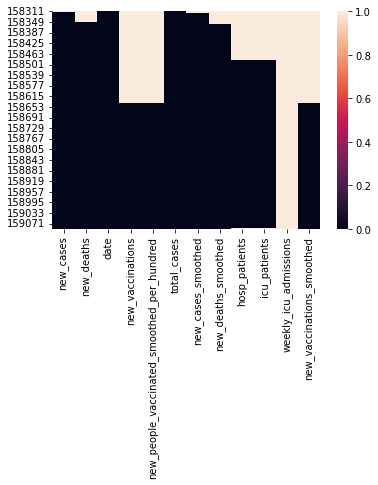

In [61]:
sns.heatmap(us_covid_data.isna())

In [62]:
us_df = country_df[country_df.country == 'US']
india_df = country_df[country_df.country == 'IN']
canada_df = country_df[country_df.country == 'CA']

In [63]:
length_date = us_df.date.value_counts(sort=False)[1:]
health_df = pd.concat([us_covid_data[us_covid_data.date == '21-10-01']] * us_df.date.value_counts(sort=False)[0])

for num, date in enumerate(us_df.date.unique()[1:]):
    new = pd.concat([us_covid_data[us_covid_data.date == date]] * length_date.iloc[num])
    health_df = pd.concat((health_df,new),axis=0)
    

In [64]:
length_date = canada_df.date.value_counts(sort=False)[1:]
first_index = canada_df.date.unique()[0]
canada_health_df = pd.concat([canada_covid_data[canada_covid_data.date == first_index]] * canada_df.date.value_counts(sort=False)[0])

for num, date in enumerate(canada_df.date.unique()[1:]):
    new = pd.concat([canada_covid_data[canada_covid_data.date == date]] * length_date.iloc[num])
    canada_health_df = pd.concat((canada_health_df,new),axis=0)
    

In [65]:
length_date = india_df.date.value_counts(sort=False)[1:]
first_index = india_df.date.unique()[0]
india_health_df = pd.concat([india_covid_data[india_covid_data.date == first_index]] * india_df.date.value_counts(sort=False)[0])

for num, date in enumerate(india_df.date.unique()[1:]):
    new = pd.concat([india_covid_data[india_covid_data.date == date]] * length_date.iloc[num])
    india_health_df = pd.concat((india_health_df,new),axis=0)
    

In [66]:
# Check that the functions worked properly.
count = 0
not_in = 0
for i in india_health_df.date.unique():
    if i in india_health_df.date.unique():
        count += 1
    else: 
        not_in += 1
        print(i)

In [67]:
# These should be the same.
print(len(us_df))
len(health_df)

51139


51139

In [68]:
us_df.reset_index(inplace=True, drop=True)
health_df.reset_index(inplace=True, drop=True)

canada_df.reset_index(inplace=True, drop=True)
canada_health_df.reset_index(inplace=True, drop=True)

india_df.reset_index(inplace=True, drop=True)
india_health_df.reset_index(inplace=True, drop=True)

In [69]:
health_df['health_date'] = health_df['date']

In [70]:
health_df.drop('date', axis=1, inplace=True)

In [71]:
us_health_df = pd.concat((us_df,health_df), axis=1)
can_health_df = pd.concat((canada_df,canada_health_df), axis=1)
india_health_df = pd.concat((india_df,india_health_df), axis=1)

In [73]:
# Should be the same
print(len(can_health_df))
len(canada_df)

8930


8930

In [75]:
print(len(india_health_df))
print(len(india_df))

14218
14218


In [76]:
can_health_df.to_csv('canada_covid_health_df.csv')
us_health_df.to_csv('us_covid_health_df.csv')
india_health_df.to_csv('india_covid_health_df.csv')